In [1]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mae
from sklearn.utils import shuffle
from PIL import Image

In [2]:
# Define locations
faces_dir = "faces"
smile_list_path = "SMILE_list.txt"
non_smile_list_path = "NON-SMILE_list.txt"

# Remove .jpg from smile and non-smile lists

with open(smile_list_path, 'r') as f:
    smile_list = [line.strip().replace('.jpg', '') for line in f.readlines()]

with open(non_smile_list_path, 'r') as f:
    non_smile_list = [line.strip().replace('.jpg', '') for line in f.readlines()]

# Images and labels
images = []
labels = []

for filename in os.listdir(faces_dir):
    if filename.endswith(".ppm"):
        img_path = os.path.join(faces_dir, filename)
        img_name = os.path.splitext(filename)[0]
        
        # Assign label
        label = 1 if img_name in smile_list else 0 if img_name in non_smile_list else None
        if label is not None:
            # Load and preproccess image
            img = Image.open(img_path).resize((64, 64))  # Resize
            img_array = np.array(img) / 255.0  # Normalize
            images.append(img_array)
            labels.append(label)


In [3]:
# shuffle
images, labels = shuffle(images, labels, random_state=1234)


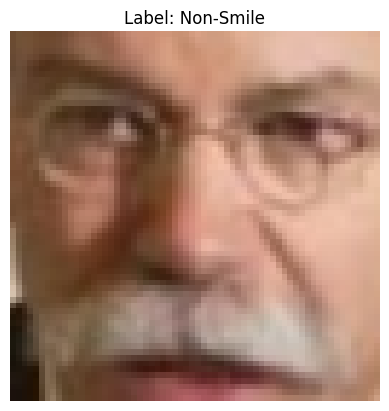

In [5]:
import matplotlib.pyplot as plt
n = 2
# Visualize an image and its label
plt.imshow(images[n])
plt.title(f"Label: {'Smile' if np.argmax(labels[n]) == 1 else 'Non-Smile'}")
plt.axis('off')
plt.show()

In [6]:
# Convert labels to integers.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_int = le.fit_transform(labels)

# Convert to a numpy arrays
images = np.array(images)
labels = to_categorical(np.array(labels), num_classes=2)  # One-hot encoding

In [179]:
labels_int[2]

np.int64(0)

In [8]:
smile_indices = np.where(labels_int == 1)[0]
not_smile_indices = np.where(labels_int == 0)[0]

In [9]:
#Store normal and abnormal instances in different data frames.
images_smile = images[smile_indices]
images_not_smile = images[not_smile_indices]

labels_smile = labels[smile_indices]
labels_not_smile = labels[not_smile_indices]

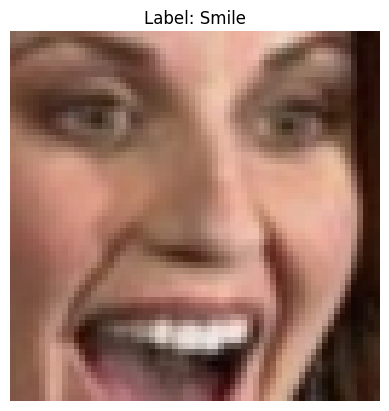

In [10]:
import matplotlib.pyplot as plt
n = 0
# Visualize an image and its label
plt.imshow(images_smile[n])
plt.title(f"Label: {'Smile' if np.argmax(labels_smile[n]) == 1 else 'Non-Smile'}")
plt.axis('off')
plt.show()

In [11]:
# Split into test and training set
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(images_smile, labels_smile,
                                                                            train_size = 0.80, random_state = 1234)

In [12]:
# Concatenate test set with abnormal instances so the test set contain both classes.
test_features = np.concatenate((test_features, images_not_smile), axis=0)
test_labels = np.concatenate((test_labels, labels_not_smile), axis=0)

In [219]:
# Sequential API model
model = Sequential([
    Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    UpSampling2D((2,2)),
    Conv2D(16, (5,5), padding='same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(32, (5,5), padding='same', activation='relu'),
    Conv2D(3, (3,3), padding='same', activation='linear')
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 16)     │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,363 (138.14 KB)

 Trainable params: 35,363 (138.14 KB)

 Non-trainable params: 0 (0.00 B)

In [220]:
# Define the optimizer. Stochastic Gradient Descent in this case.
optimizer = SGD(learning_rate = 0.01)

model.compile(optimizer = optimizer,
              loss = "mse",
              metrics = ['mse'])

# Fit
history = model.fit(train_features, train_features, validation_split = 0.15, epochs=10, batch_size=32, verbose = 1)

# Save
model.save("autoencoder.keras")

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.2318 - mse: 0.2318 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.02

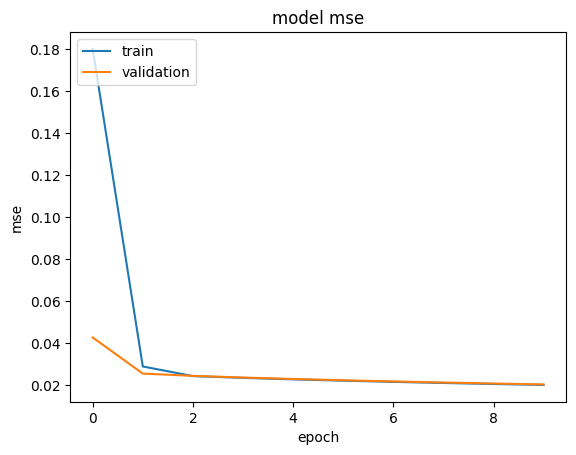

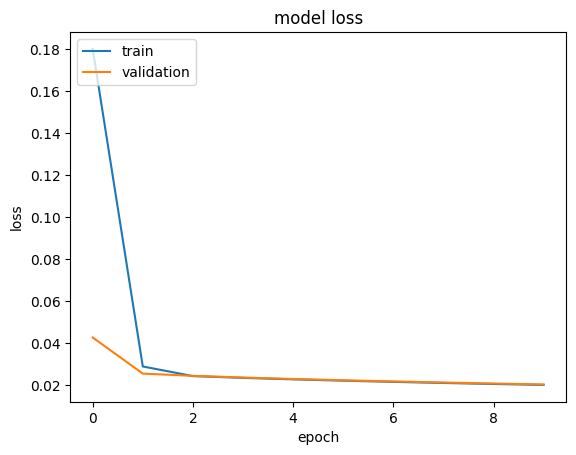

In [221]:
# plot history

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [222]:
# Evaluate the model on the train set and print the loss and mse.
model.evaluate(train_features, train_features) # [loss, mse]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0200 - mse: 0.0200


[0.019981374964118004, 0.019981374964118004]

In [223]:
# Evaluate the model on the test set and print the loss and mse.
model.evaluate(test_features, test_features) # [loss, mse]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0195 - mse: 0.0195


[0.018885407596826553, 0.018885407596826553]

In [224]:
# Make predictions on the train set.
reconstructions = model.predict(train_features)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


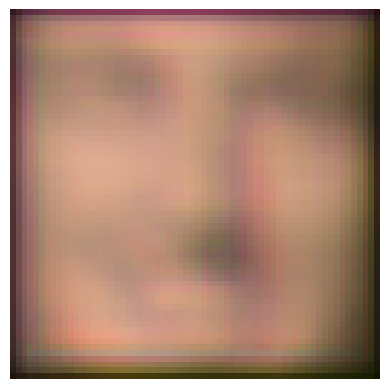

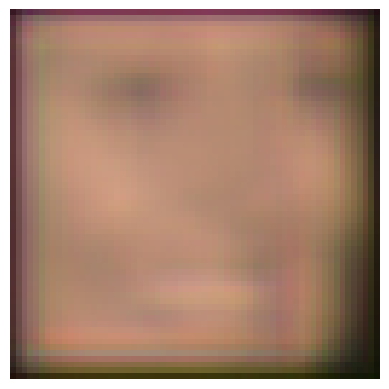

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0015015732..0.6536176].


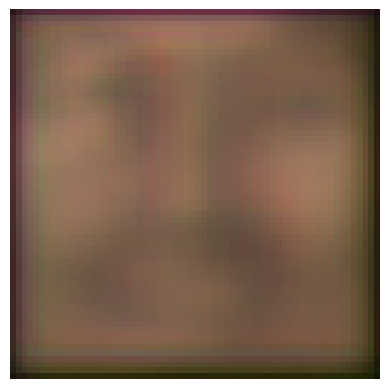

In [225]:
# Print first n faces reconstructions
n = 3

for i in range(n):
    plt.imshow(reconstructions[i])
    plt.axis('off')
    plt.show()

In [226]:
print(reconstructions[0].shape)

(64, 64, 3)


In [227]:
from scipy.stats import wasserstein_distance

# Distancia entre histogramas
def errors(reconstructions, features):
    hist_errors = [
        wasserstein_distance(np.histogram(features[i].flatten(), bins=256)[0],
                            np.histogram(reconstructions[i].flatten(), bins=256)[0])
        for i in range(len(features))
    ]

    return hist_errors


In [228]:
errors_train_normal = errors(reconstructions, train_features)

print(np.mean(errors_train_normal))

quantiles = np.quantile(errors_train_normal, [0.0, 0.25, 0.50, 0.75, .90, 1.0])
print(quantiles)

10.067545572916666
[ 2.5390625   7.11328125  9.41015625 12.37304688 15.9296875  24.390625  ]


In [237]:
# threshold
t = 18

In [230]:
test_reconstructions = model.predict(test_features)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017186746..0.8614564].


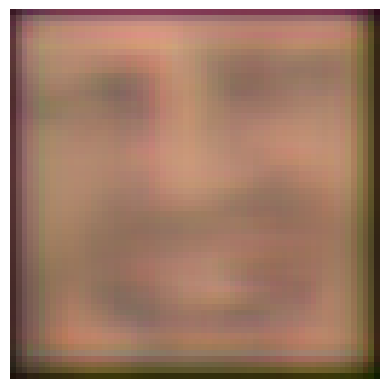

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0065815914..0.7955478].


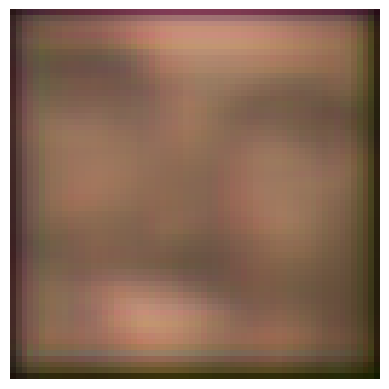

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012265213..0.8457528].


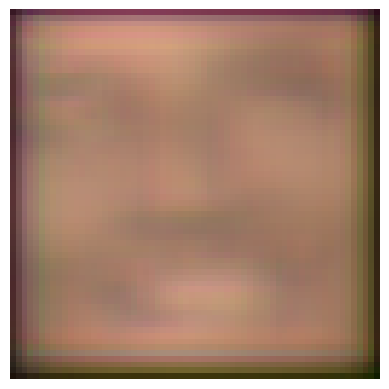

In [231]:
# Print first n test faces reconstructions
n = 3

for i in range(n):
    plt.imshow(test_reconstructions[i])
    plt.axis('off')
    plt.show()

In [232]:
test_errors = errors(test_reconstructions, test_features)

In [233]:
len(test_errors)

723

In [239]:
test_predictions = np.where(np.array(test_errors) > t, 0, 1)

print(test_errors[0:5])
print(test_predictions[0:5])

[np.float64(8.9765625), np.float64(8.828125), np.float64(7.796875), np.float64(11.8203125), np.float64(2.9765625)]
[1 1 1 1 1]


In [235]:
test_labels_smile = [test_labels[i][1] for i in range(len(test_labels))]

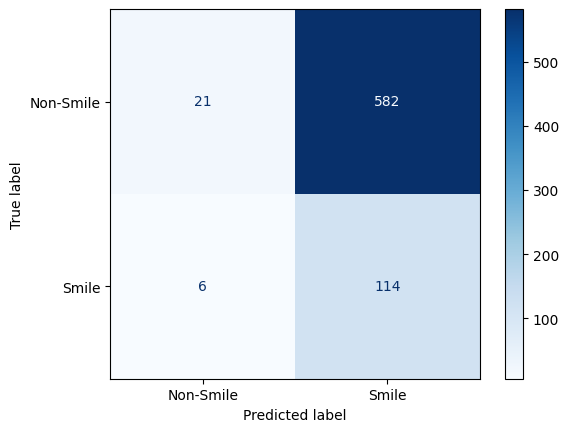

In [240]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels_smile, test_predictions)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Smile", "Smile"])
disp.plot(cmap="Blues")